<a href="https://colab.research.google.com/github/thunwaaa/sign_language/blob/main/examples/hand_landmarker/python/hand_landmarker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2023 The MediaPipe Authors. All Rights Reserved.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Hand Landmarks Detection with MediaPipe Tasks

This notebook shows you how to use MediaPipe Tasks Python API to detect hand landmarks from images.

## Preparation

Let's start with installing MediaPipe.

In [1]:
!pip install protobuf>=5.29.1

In [2]:
!pip install opencv-python

In [3]:
!pip install mediapipe

In [5]:
!pip install numpy>=2.0.0

Then download an off-the-shelf model bundle. Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/hand_landmarker#models) for more information about this model bundle.

In [4]:
!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

## Visualization utilities

In [6]:
#@markdown We implemented some functions to visualize the hand landmark detection results. <br/> Run the following cell to activate the functions.

import cv2
import numpy as np
import mediapipe as mp
from mediapipe import solutions

# Setup MediaPipe solutions
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

# Constants
MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54)  # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
    hand_landmarks_list = detection_result.multi_hand_landmarks
    handedness_list = detection_result.multi_handedness
    annotated_image = np.copy(rgb_image)

    # Loop through the detected hands to visualize.
    for idx in range(len(hand_landmarks_list)):
        hand_landmarks = hand_landmarks_list[idx]
        handedness = handedness_list[idx]

        # Draw the hand landmarks directly using MediaPipe's drawing utilities
        mp_drawing.draw_landmarks(
            annotated_image,
            hand_landmarks,
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())

        # Get the top left corner of the detected hand's bounding box.
        height, width, _ = annotated_image.shape
        x_coordinates = [landmark.x for landmark in hand_landmarks.landmark]
        y_coordinates = [landmark.y for landmark in hand_landmarks.landmark]
        text_x = int(min(x_coordinates) * width)
        text_y = int(min(y_coordinates) * height) - MARGIN

        # Draw handedness (left or right hand) on the image.
        cv2.putText(annotated_image, f"{handedness.classification[0].label}",
                    (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                    FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

    return annotated_image

## Download test image

Let's grab a test image that we'll use later. The image is from [Unsplash](https://unsplash.com/photos/mt2fyrdXxzk).

In [7]:
#

Optionally, you can upload your own image. If you want to do so, uncomment and run the cell below.

In [ ]:
# @title
import cv2
import mediapipe as mp
import numpy as np
import time
import os

from google.colab import files
# อัปโหลดวิดีโอหลายๆ ไฟล์
uploaded = files.upload()

# แสดงรายชื่อไฟล์วิดีโอที่อัปโหลด
print("ไฟล์วิดีโอที่อัปโหลด:")
for filename in uploaded.keys():
    print(f"- {filename}")

# เก็บพาธของไฟล์วิดีโอทั้งหมด
video_paths = list(uploaded.keys())

## Running inference and visualizing the results

Here are the steps to run hand landmark detection using MediaPipe.

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/hand_landmarker/python) to learn more about configuration options that this solution supports.


In [ ]:
# @title
# import urllib.request

# # MediaPipe initialization
# BaseOptions = mp.tasks.BaseOptions
# HandLandmarker = mp.tasks.vision.HandLandmarker
# HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
# VisionRunningMode = mp.tasks.vision.RunningMode

# # Create a hand landmarker instance with the video mode
# options = HandLandmarkerOptions(
#     base_options=BaseOptions(model_asset_path='hand_landmarker.task'),
#     running_mode=VisionRunningMode.VIDEO,
#     num_hands=2)

# # Open the video file
# cap = cv2.VideoCapture(input_video_path)
# if not cap.isOpened():
#     print(f"Error: Could not open video file {input_video_path}")
#     exit()

# # Get video properties
# width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
# height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
# fps = cap.get(cv2.CAP_PROP_FPS)
# total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# # Create video writer for output
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# with HandLandmarker.create_from_options(options) as landmarker:
#     # Initialize timestamp
#     timestamp = 0
#     frame_count = 0

#     while cap.isOpened():
#         success, frame = cap.read()
#         if not success:
#             print("End of video or error reading frame.")
#             break

#         frame_count += 1
#         # Optional: Print progress
#         if frame_count % 10 == 0:
#             print(f"Processing frame {frame_count}/{total_frames} ({frame_count/total_frames*100:.1f}%)")

#         # Convert to RGB (MediaPipe requirement)
#         frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)

#         # Process the frame
#         results = landmarker.detect_for_video(mp_image, timestamp)
#         timestamp += 1

#         # Create a black canvas instead of using the original frame
#         canvas = np.zeros((height, width, 3), dtype=np.uint8)

#         # Draw hand landmarks
#         if results.hand_landmarks:
#             for idx, hand_landmarks in enumerate(results.hand_landmarks):
#                 # Get hand label (LEFT or RIGHT)
#                 handedness = results.handedness[idx][0].category_name

#                 # Get center of hand for text placement
#                 x_values = [landmark.x for landmark in hand_landmarks]
#                 y_values = [landmark.y for landmark in hand_landmarks]
#                 center_x = int(sum(x_values) / len(x_values) * width)
#                 center_y = int(sum(y_values) / len(y_values) * height)

#                 # Draw connections with white color
#                 for connection in mp.solutions.hands.HAND_CONNECTIONS:
#                     start_idx = connection[0]
#                     end_idx = connection[1]

#                     start_point = (int(hand_landmarks[start_idx].x * width),
#                                   int(hand_landmarks[start_idx].y * height))
#                     end_point = (int(hand_landmarks[end_idx].x * width),
#                                 int(hand_landmarks[end_idx].y * height))

#                     cv2.line(canvas, start_point, end_point, (255, 255, 255), 2)  # White lines

#                 # Draw landmarks with light blue color
#                 for landmark in hand_landmarks:
#                     landmark_point = (int(landmark.x * width),
#                                      int(landmark.y * height))
#                     cv2.circle(canvas, landmark_point, 5, (255, 200, 0), -1)  # Light blue dots

#                 # Display hand label
#                 color = (255, 100, 100) if handedness == "LEFT" else (100, 100, 255)  # Different colors for left/right
#                 text_position = (center_x, center_y - 30)
#                 cv2.putText(canvas, handedness, text_position,
#                            cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

#         # Write the canvas to output video
#         out.write(canvas)

#         # Optional: Display the frame (comment out for faster processing)
#         # cv2.imshow('Processing Video', canvas)
#         # if cv2.waitKey(1) & 0xFF == ord('q'):
#         #     break

# # Release resources
# cap.release()
# out.release()
# cv2.destroyAllWindows()

# print(f"Processing complete. Output saved to {output_video_path}")

# files.download(output_video_path)

In [67]:
import os
import cv2
import json
import mediapipe as mp
from google.colab import files

def process_video_to_json(input_video_path, gesture_label):
    """
    Process a video and extract hand landmarks to a JSON file

    Args:
        input_video_path: Path to the input video file
        gesture_label: Label for the gesture being performed in the video
    """
    # MediaPipe initialization
    BaseOptions = mp.tasks.BaseOptions
    HandLandmarker = mp.tasks.vision.HandLandmarker
    HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
    VisionRunningMode = mp.tasks.vision.RunningMode

    # Create output JSON path
    output_json_path = os.path.splitext(input_video_path)[0] + "_landmarks.json"

    # Create a hand landmarker instance with the video mode
    options = HandLandmarkerOptions(
        base_options=BaseOptions(model_asset_path='hand_landmarker.task'),
        running_mode=VisionRunningMode.VIDEO,
        num_hands=2)

    # Open the video file
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file {input_video_path}")
        return None

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Initialize data structure for JSON
    video_landmarks = {
        'video_id': os.path.splitext(os.path.basename(input_video_path))[0],
        'gesture_label': gesture_label,
        'fps': fps,
        'total_frames': total_frames,
        'frames': []
    }

    with HandLandmarker.create_from_options(options) as landmarker:
        # Initialize timestamp
        timestamp = 0
        frame_count = 0

        while cap.isOpened():
            success, frame = cap.read()
            if not success:
                break

            frame_count += 1
            # Optional: Print progress
            if frame_count % 10 == 0:
                print(f"Processing {input_video_path} - frame {frame_count}/{total_frames} ({frame_count/total_frames*100:.1f}%)")

            # Convert to RGB (MediaPipe requirement)
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)

            # Process the frame
            results = landmarker.detect_for_video(mp_image, timestamp)

            # Calculate timestamp in seconds
            timestamp_seconds = frame_count / fps

            # Frame landmark data
            frame_data = {
                'frame_number': frame_count,
                'timestamp': timestamp_seconds,
                'hands': []
            }

            # Write hand landmarks to JSON
            if results.hand_landmarks:
                for idx, hand_landmarks in enumerate(results.hand_landmarks):
                    # Get hand label (LEFT or RIGHT)
                    handedness = results.handedness[idx][0].category_name

                    # Prepare hand landmarks
                    hand_data = {
                        'hand_type': handedness,
                        'landmarks': []
                    }

                    # Process each landmark
                    for landmark_idx, landmark in enumerate(hand_landmarks):
                        hand_data['landmarks'].append({
                            'landmark_id': landmark_idx,
                            'x': landmark.x,
                            'y': landmark.y,
                            'z': landmark.z
                        })

                    frame_data['hands'].append(hand_data)

            # Add frame data if landmarks were detected
            if frame_data['hands']:
                video_landmarks['frames'].append(frame_data)

            timestamp += 1

    # Release resources
    cap.release()

    # Save to JSON
    with open(output_json_path, 'w', encoding='utf-8') as jsonfile:
        json.dump(video_landmarks, jsonfile, ensure_ascii=False, indent=4)

    print(f"Processing complete. Landmarks saved to {output_json_path}")
    return output_json_path

# อัปโหลดวิดีโอหลายๆ ไฟล์
uploaded = files.upload()

# ให้ผู้ใช้ระบุท่าทางสำหรับทุกวิดีโอ
gesture_label = input("กรุณาระบุชื่อท่าทาง (เช่น hello, thank_you, เป็นต้น): ")

# เก็บ JSON paths
json_paths = []

# ประมวลผลวิดีโอแต่ละไฟล์
for video_path in uploaded.keys():
    json_path = process_video_to_json(video_path, gesture_label)
    if json_path:
        json_paths.append(json_path)

# ดาวน์โหลด JSON ทุกไฟล์
for json_path in json_paths:
    files.download(json_path)

Saving (49).สนิท.mp4 to (49).สนิท.mp4
กรุณาระบุชื่อท่าทาง (เช่น hello, thank_you, เป็นต้น): สนิท
Processing (49).สนิท.mp4 - frame 10/109 (9.2%)
Processing (49).สนิท.mp4 - frame 20/109 (18.3%)
Processing (49).สนิท.mp4 - frame 30/109 (27.5%)
Processing (49).สนิท.mp4 - frame 40/109 (36.7%)
Processing (49).สนิท.mp4 - frame 50/109 (45.9%)
Processing (49).สนิท.mp4 - frame 60/109 (55.0%)
Processing (49).สนิท.mp4 - frame 70/109 (64.2%)
Processing (49).สนิท.mp4 - frame 80/109 (73.4%)
Processing (49).สนิท.mp4 - frame 90/109 (82.6%)
Processing (49).สนิท.mp4 - frame 100/109 (91.7%)
Processing complete. Landmarks saved to (49).สนิท_landmarks.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Data Processing

รวบรวมข้อมูลจากทุกไฟล์ JSONในโฟลเดอร์เพื่อเพิ่มความหลากหลายและความครอบคลุมของข้อมูล

In [68]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pathlib import Path

def preprocess_sign_language_data(data_directory):
    """
    Preprocess sign language data from JSON files

    Args:
        data_directory: Path to directory containing JSON files

    Returns:
        X: Processed feature data
        y: Corresponding labels
    """
    # เก็บข้อมูลทั้งหมด
    all_landmarks = []
    all_labels = []

    # เพิ่มการตรวจสอบก่อนเริ่มทำงาน
    if not os.path.exists(data_directory):
        print(f"Error: Directory {data_directory} does not exist!")
        return [], [], None # Return empty lists and None instead of None, None, None

   # วนลูปผ่านไฟล์ JSON โดยตรง
    for json_file in os.listdir(data_directory):
        if json_file.endswith('.json'):
            file_path = os.path.join(data_directory, json_file)

            try:
                # โหลดข้อมูล JSON
                with open(file_path, 'r') as f:
                    video_data = json.load(f)

                # สกัดคุณลักษณะ
                processed_landmarks = process_video_landmarks(video_data)

                # เพิ่มข้อมูล
                all_landmarks.append(processed_landmarks)
                # ใช้ชื่อไฟล์เป็นฉลาก
                all_labels.append(json_file.split('_')[0])

            except Exception as e:
                print(f"Error processing file {file_path}: {e}")

    # ถ้าไม่พบไฟล์ JSON เลย
    if not all_landmarks:
        print(f"No JSON files found in directory {data_directory}")
        return [], [], None # Return empty lists and None instead of None, None, None

    # แปลง list เป็น numpy array
    X = np.array(all_landmarks)

    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(all_labels)

    # พิมพ์ข้อมูลดีบัก
    print(f"Processed {len(X)} samples")
    print(f"Labels: {label_encoder.classes_}")

    return X, y, label_encoder

def process_video_landmarks(video_data):
    """
    แปลงข้อมูลแลนด์มาร์คจาก JSON เป็นชุดข้อมูลที่เหมาะสำหรับโมเดล

    Args:
        video_data: ข้อมูล JSON ของวิดีโอ

    Returns:
        processed_landmarks: อาร์เรย์ของแลนด์มาร์ค
    """
    # เลือกเฟรมที่มีการตรวจจับมือ
    hand_frames = [frame for frame in video_data['frames'] if frame['hands']]

    # เลือกเฟรมทั้งหมด (หรือจำกัดจำนวนเฟรม)
    selected_frames = hand_frames[:30]  # จำกัดที่ 30 เฟรม

    # เตรียมอาร์เรย์เก็บแลนด์มาร์ค
    landmarks_sequence = []

    for frame in selected_frames:
        # สำหรับแต่ละมือในเฟรม
        frame_landmarks = []
        for hand in frame['hands']:
            # สกัด x, y, z ของแต่ละจุด
            hand_landmarks = [
                [landmark['x'], landmark['y'], landmark['z']]
                for landmark in hand['landmarks']
            ]
            frame_landmarks.extend(hand_landmarks)

        # padding หากมีจุดไม่ครบ
        while len(frame_landmarks) < 42:  # 21 จุด * 2 มือ
            frame_landmarks.append([0, 0, 0])

        landmarks_sequence.append(frame_landmarks[:42])

    # padding sequence ให้มีความยาวคงที่
    while len(landmarks_sequence) < 30:
        landmarks_sequence.append([[0, 0, 0]] * 42)

    # เพิ่มในฟังก์ชัน process_video_landmarks เพื่อดีบัก
    print("Video data keys:", video_data.keys())
    print("Number of frames:", len(video_data['frames']))
    print("First frame hands:", video_data['frames'][0]['hands'])

    return np.array(landmarks_sequence)


# ตัวอย่างการใช้งาน
data_directory = '/content/สวัสดี'  # ตรวจสอบให้แน่ใจว่าพาธนี้ถูกต้อง
# Check if the directory exists
if not os.path.exists(data_directory):
    print(f"Error: Directory '{data_directory}' does not exist. Please create it and add your JSON files.")
else:
    # Check if the directory contains any JSON files
    json_files = [f for f in os.listdir(data_directory) if f.endswith('.json')]
    if not json_files:
        print(f"Error: Directory '{data_directory}' does not contain any JSON files. Please add your JSON files.")
    else:
        X, y, label_encoder = preprocess_sign_language_data(data_directory)

        if len(X) > 0 and len(y) > 0 and label_encoder is not None:

          # เพิ่มบรรทัดนี้ก่อนการแบ่งข้อมูล
            print("X shape:", X.shape)
            print("y shape:", y.shape)
            print("X data type:", X.dtype)
            print("First sample landmarks:\n", X[0])
            print("Labels:", y)
            # แบ่งข้อมูล
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42
            )

            print("Shape of training data:", X_train.shape)
            print("Unique labels:", label_encoder.classes_)
        else:
            print("No data to process. Check your JSON files.")

Video data keys: dict_keys(['video_id', 'gesture_label', 'fps', 'total_frames', 'frames'])
Number of frames: 66
First frame hands: [{'hand_type': 'Right', 'landmarks': [{'landmark_id': 0, 'x': 0.3289569914340973, 'y': 0.8239549398422241, 'z': -2.096321196631834e-07}, {'landmark_id': 1, 'x': 0.3376166820526123, 'y': 0.7892253398895264, 'z': -0.017941605299711227}, {'landmark_id': 2, 'x': 0.35374364256858826, 'y': 0.7560994029045105, 'z': -0.037500470876693726}, {'landmark_id': 3, 'x': 0.3636321425437927, 'y': 0.7219166159629822, 'z': -0.05663178488612175}, {'landmark_id': 4, 'x': 0.36658042669296265, 'y': 0.6953893899917603, 'z': -0.07675578445196152}, {'landmark_id': 5, 'x': 0.3945050835609436, 'y': 0.8047327399253845, 'z': -0.033595211803913116}, {'landmark_id': 6, 'x': 0.42055875062942505, 'y': 0.7907269597053528, 'z': -0.053264256566762924}, {'landmark_id': 7, 'x': 0.4330204427242279, 'y': 0.7756574749946594, 'z': -0.06876668334007263}, {'landmark_id': 8, 'x': 0.4375600516796112, 'y

# Data Augmentation

เพิ่มความหลากหลายของข้อมูล สร้างข้อมูลเทียม เพิ่มความทนทานของโมเดล

In [69]:
import random

class SignLanguageDataAugmentation:
    def __init__(self, original_data):
        """
        เตรียมการเพิ่มความหลากหลายของข้อมูลภาษามือ

        Args:
            original_data: ข้อมูลแลนด์มาร์คเดิม
        """
        self.original_data = original_data

    def add_noise(self, data, noise_level=0.02):
        """
        เพิ่มความคลาดเคลื่อนเล็กน้อยในข้อมูล

        Args:
            data: ข้อมูลแลนด์มาร์ค
            noise_level: ระดับความคลาดเคลื่อน

        Returns:
            ข้อมูลที่เพิ่มความคลาดเคลื่อน
        """
        noise = np.random.normal(
            loc=0,
            scale=noise_level,
            size=data.shape
        )
        return data + noise

    def time_warping(self, data, max_warp=5):
        """
        ยืดหรือบีบเวลาของลำดับการเคลื่อนไหว

        Args:
            data: ข้อมูลแลนด์มาร์ค
            max_warp: จำนวนเฟรมสูงสุดที่จะยืดหรือบีบ

        Returns:
            ข้อมูลที่ถูกดัดแปลงเวลา
        """
        # สุ่มเลือกจุดที่จะยืดหรือบีบ
        warp_point = random.randint(0, len(data) - max_warp - 1)

        # สร้างข้อมูลใหม่
        warped_data = np.copy(data)

        # ซ้ำหรือลบเฟรมบางส่วน
        insert_point = random.randint(0, max_warp)
        warped_data = np.insert(
            warped_data,
            warp_point + insert_point,
            warped_data[warp_point:warp_point+max_warp],
            axis=0
        )

        # ตัดให้มีความยาวคงเดิม
        return warped_data[:len(data)]

    def hand_rotation(self, data):
        """
        หมุนตำแหน่งมือ

        Args:
            data: ข้อมูลแลนด์มาร์ค

        Returns:
            ข้อมูลที่ถูกหมุน
        """
        # สุ่มมุมหมุน
        angle = np.random.uniform(-30, 30)

        # แปลงเป็นเรเดียน
        angle_rad = np.deg2rad(angle)

        # เมทริกซ์หมุน
        rotation_matrix = np.array([
            [np.cos(angle_rad), -np.sin(angle_rad)],
            [np.sin(angle_rad), np.cos(angle_rad)]
        ])

        # คัดลอกข้อมูล
        rotated_data = np.copy(data)

        # หมุนพิกัด x, y
        for i in range(len(rotated_data)):
            for j in range(0, len(rotated_data[i]), 3):
                rotated_data[i][j:j+2] = np.dot(
                    rotation_matrix,
                    rotated_data[i][j:j+2]
                )

        return rotated_data

    def generate_augmented_data(self, num_augmentations=5):
        """
        สร้างชุดข้อมูลเพิ่มเติม

        Args:
            num_augmentations: จำนวนข้อมูลที่ต้องการสร้าง

        Returns:
            ชุดข้อมูลที่ถูกเพิ่มความหลากหลาย
        """
        augmented_data = []

        for _ in range(num_augmentations):
            # สุ่มเลือกข้อมูลต้นฉบับ
            base_data = random.choice(self.original_data)

            # เพิ่มความหลากหลาย
            augmented_sample = self.add_noise(base_data)
            augmented_sample = self.time_warping(augmented_sample)
            augmented_sample = self.hand_rotation(augmented_sample)

            augmented_data.append(augmented_sample)

        return augmented_data

# ตัวอย่างการใช้งาน
# สมมติ X คือชุดข้อมูลเดิม
augmentor = SignLanguageDataAugmentation(X)
augmented_X = augmentor.generate_augmented_data()

# รวมข้อมูล
X_augmented = np.concatenate([X, augmented_X])
y_augmented = np.concatenate([y, y[:len(augmented_X)]])

# Feature Engineering

สกัดคุณลักษณะพิเศษ
คำนวณความเร็ว ความเร่ง
วิเคราะห์คุณสมบัติทางสถิติ



In [73]:
from scipy.stats import skew, kurtosis

class SignLanguageFeatureExtractor:
    def __init__(self, landmarks_data):
        """
        สกัดคุณลักษณะพิเศษจากข้อมูลแลนด์มาร์ค

        Args:
            landmarks_data: ข้อมูลแลนด์มาร์คภาษามือ
        """
        self.landmarks_data = landmarks_data

    def calculate_hand_velocity(self):
        """
        คำนวณความเร็วของการเคลื่อนไหวมือ

        Returns:
            อาร์เรย์ของความเร็วมือในแต่ละเฟรม
        """
        velocities = []
        for sequence in self.landmarks_data:
            frame_velocities = []
            for frame_idx in range(1, len(sequence)):
                # คำนวณการเปลี่ยนแปลงตำแหน่ง
                prev_frame = sequence[frame_idx-1]
                curr_frame = sequence[frame_idx]

                # คำนวณความเร็ว
                frame_velocity = np.linalg.norm(
                    curr_frame[:21*3] - prev_frame[:21*3]
                )
                frame_velocities.append(frame_velocity)

            velocities.append(frame_velocities)

        return np.array(velocities)

    def calculate_hand_acceleration(self):
        """
        คำนวณความเร่งของการเคลื่อนไหวมือ

        Returns:
            อาร์เรย์ของความเร่งมือในแต่ละเฟรม
        """
        accelerations = []
        velocities = self.calculate_hand_velocity()

        for velocity_sequence in velocities:
            frame_accelerations = []
            for frame_idx in range(1, len(velocity_sequence)):
                # คำนวณการเปลี่ยนแปลงความเร็ว
                acceleration = abs(
                    velocity_sequence[frame_idx] -
                    velocity_sequence[frame_idx-1]
                )
                frame_accelerations.append(acceleration)

            accelerations.append(frame_accelerations)

        return np.array(accelerations)

    def calculate_statistical_features(self):
        """
        คำนวณคุณลักษณะทางสถิติ

        Returns:
            พจนานุกรมของคุณลักษณะทางสถิติ
        """
        features = []

        for sequence in self.landmarks_data:
            sequence_features = {}

            # คำนวณคุณลักษณะสำหรับแต่ละมือ
            for hand_start in [0, 21*3]:
                hand_landmarks = sequence[:, hand_start:hand_start+21*3]

                # สถิติพื้นฐาน
                sequence_features.update({
                    f'hand_{hand_start//63}_mean': np.mean(hand_landmarks),
                    f'hand_{hand_start//63}_std': np.std(hand_landmarks),
                    f'hand_{hand_start//63}_skewness': skew(hand_landmarks.flatten()),
                    f'hand_{hand_start//63}_kurtosis': kurtosis(hand_landmarks.flatten())
                })

            features.append(sequence_features)

        return features

    def extract_advanced_features(self):

      # รวบรวมคุณลักษณะต่างๆ
      velocities = self.calculate_hand_velocity()
      accelerations = self.calculate_hand_acceleration()
      statistical_features = self.calculate_statistical_features()

      # แปลงเป็นรูปแบบที่เหมาะสมสำหรับโมเดล
      feature_matrix = []
      for i in range(len(self.landmarks_data)):
          # แปลงค่าเดี่ยวให้เป็น array ด้วย np.array() หรือใช้ list
          velocity_mean = np.mean(velocities[i])  # ค่าเดี่ยว
          acceleration_mean = np.mean(accelerations[i])  # ค่าเดี่ยว
          stat_features = list(statistical_features[i].values())  # list ของค่า

          # รวมคุณลักษณะโดยสร้างเป็น list ก่อน แล้วค่อยแปลงเป็น numpy array
          features = np.array([velocity_mean, acceleration_mean] + stat_features)
          feature_matrix.append(features)

      return np.array(feature_matrix)

# ตัวอย่างการใช้งาน
feature_extractor = SignLanguageFeatureExtractor(X)
X_advanced_features = feature_extractor.extract_advanced_features()

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-73-eb37d04d6e19>:82: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample

# Model Selection & Hyperparameter Tuning

ทดสอบหลายสถาปัตยกรรม
LSTM, CNN, Transformer
เปรียบเทียบประสิทธิภาพ และ ค้นหาพารามิเตอร์ที่เหมาะสม
ใช้ Random Search
ปรับแต่งโมเดลให้ดีขึ้น

In [77]:
!pip install scikeras

In [81]:
import tensorflow as tf
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier
from scipy.stats import uniform, randint

class SignLanguageModelSelector:
    def __init__(self, X_train, y_train, X_test, y_test):
        """
        เลือกและปรับแต่งโมเดลสำหรับภาษามือ

        Args:
            X_train: ข้อมูลฝึกอบรม
            y_train: ป้ายกำกับการฝึกอบรม
            X_test: ข้อมูลทดสอบ
            y_test: ป้ายกำกับการทดสอบ
        """
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

        # โมเดลที่จะทดสอบ
        self.models = {
            'LSTM': self.create_lstm_model,
            'CNN': self.create_cnn_model,
            'Transformer': self.create_transformer_model
        }

    def create_lstm_model(self, units=64, dropout=0.3):
      """
      สร้างโมเดล LSTM

      Args:
          units: จำนวนหน่วยใน LSTM layer
          dropout: อัตราการ dropout

      Returns:
          โมเดล Keras
      """
      # รับข้อมูลรูปร่าง (30, 42, 3) - ปรับตามรูปร่างจริงของข้อมูล
      model = tf.keras.Sequential([
          # เพิ่ม Reshape layer เพื่อแบนมิติสุดท้าย
          tf.keras.layers.Reshape((30, 42*3), input_shape=(30, 42, 3)),

          tf.keras.layers.LSTM(
              units,
              return_sequences=True
          ),
          tf.keras.layers.Dropout(dropout),
          tf.keras.layers.LSTM(units//2),
          tf.keras.layers.Dense(
              len(np.unique(self.y_train)),
              activation='softmax'
          )
      ])

      model.compile(
          optimizer='adam',
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy']
      )

      return model

    def create_cnn_model(self, filters=64, kernel_size=3):
      """
      สร้างโมเดล CNN

      Args:
          filters: จำนวน filters
          kernel_size: ขนาด kernel

      Returns:
          โมเดล Keras
      """
      model = tf.keras.Sequential([
          # ใช้ Conv2D แทน Conv1D
          tf.keras.layers.Conv2D(
              filters,
              kernel_size=(kernel_size, kernel_size),  # kernel size ต้องเป็น tuple สำหรับ Conv2D
              input_shape=(30, 42, 3),
              activation='relu'
          ),
          tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(
              len(np.unique(self.y_train)),
              activation='softmax'
          )
      ])

      model.compile(
          optimizer='adam',
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy']
      )

      return model

    def create_transformer_model(self, num_heads=4, ff_dim=32):
        """
        สร้างโมเดล Transformer

        Args:
            num_heads: จำนวน attention heads
            ff_dim: ขนาดของ feed-forward layer

        Returns:
            โมเดล Keras
        """
        # ปรับรูปร่างของ input
        inputs = tf.keras.Input(shape=(30, 42, 3))  # ปรับตามรูปร่างจริงของข้อมูล

        # แบนมิติสุดท้าย
        x = tf.keras.layers.Reshape((30, 42*3))(inputs)

        # Transformer Encoder
        for _ in range(2):
            x = tf.keras.layers.MultiHeadAttention(
                num_heads=num_heads,
                key_dim=ff_dim
            )(x, x)
            x = tf.keras.layers.LayerNormalization()(x)

        x = tf.keras.layers.GlobalAveragePooling1D()(x)
        x = tf.keras.layers.Dense(ff_dim, activation='relu')(x)
        outputs = tf.keras.layers.Dense(
            len(np.unique(self.y_train)),
            activation='softmax'
        )(x)

        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    def hyperparameter_tuning(self):
      # เตรียม Keras Classifier
      model = KerasClassifier(
          model=self.create_lstm_model,  # เปลี่ยนจาก build_fn เป็น model
          verbose=0
      )

      # ปรับช่วงพารามิเตอร์
      param_dist = {
          'model__units': [32, 64, 128],  # เพิ่ม model__ ข้างหน้า
          'model__dropout': uniform(0.2, 0.5),
          'batch_size': [16, 32, 64],
          'epochs': [50, 100, 200]
      }

      # ตรวจสอบจำนวนข้อมูล
      if len(self.X_train) < 10:  # ถ้าข้อมูลน้อยเกินไป
          print("ข้อมูลมีจำนวนน้อยเกินไปสำหรับ hyperparameter tuning")
          return model  # คืนค่าโมเดลเริ่มต้น

      # กำหนด cv ตามขนาดข้อมูล
      cv_value = min(3, len(self.X_train) // 2)

      # Random Search
      random_search = RandomizedSearchCV(
          estimator=model,
          param_distributions=param_dist,
          n_iter=10,
          cv=cv_value,
          scoring='accuracy'
      )

      # ตรวจสอบว่ามีพื้นที่พอสำหรับ validation_split หรือไม่
      if len(self.X_train) > 5:  # ถ้ามีข้อมูลมากกว่า 5 ตัวอย่าง
          random_search.fit(
              self.X_train,
              self.y_train,
              validation_split=0.2
          )
      else:
          random_search.fit(
              self.X_train,
              self.y_train
          )

      return random_search.best_estimator_

    def compare_models(self):
      results = {}

      #ตรวจสอบจำนวนข้อมูลฝึกอบรม
      if len(self.X_train) < 10:  # หากข้อมูลน้อยกว่า 10 ตัวอย่าง
          validation_split = None
          validation_data = None
      else:
          validation_split = 0.2
          validation_data = None

      for name, model_creator in self.models.items():
          # สร้างโมเดล
          model = model_creator()

          #ฝึกอบรม - ปรับการใช้ validation
          if validation_split:
              history = model.fit(
                  self.X_train, self.y_train,
                  validation_split=validation_split,
                  epochs=50,
                  batch_size=min(32, len(self.X_train))  # ปรับขนาด batch ตามข้อมูล
              )
          else:
              history = model.fit(
                  self.X_train, self.y_train,
                  epochs=50,
                  batch_size=min(32, len(self.X_train))
              )

          #ประเมินผล
          test_loss, test_accuracy = model.evaluate(
              self.X_test, self.y_test
          )

          results[name] = {
              'test_accuracy': test_accuracy,
              'test_loss': test_loss,
              'training_history': history
          }

      return results

# ตัวอย่างการใช้งาน
model_selector = SignLanguageModelSelector(
    X_train, y_train, X_test, y_test
)

# เปรียบเทียบโมเดล
model_comparison = model_selector.compare_models()

# ปรับแต่งพารามิเตอร์
best_model = model_selector.hyperparameter_tuning()

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00



*   เทรนโมเดลที่ดีที่สุดให้ละเอียดยิ่งขึ้นด้วยการเทรนหลายรอบ
*   เพิ่มประสิทธิภาพด้วยการเพิ่มข้อมูล (Data Augmentation)
*  ประเมินและวิเคราะห์ผลลัพธ์อย่างละเอียด
*   เตรียมโมเดลสำหรับการนำไปใช้งาน





ไม่มีการเปรียบเทียบโมเดล ใช้ LSTM เป็นค่าเริ่มต้น


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0971 - loss: 2.3357
Epoch 1: val_accuracy improved from -inf to 0.12000, saving model to best_LSTM_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.0972 - loss: 2.3341 - val_accuracy: 0.1200 - val_loss: 2.2884 - learning_rate: 0.0010
Epoch 2/50
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1069 - loss: 2.3086
Epoch 2: val_accuracy did not improve from 0.12000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1038 - loss: 2.3088 - val_accuracy: 0.1200 - val_loss: 2.2846 - learning_rate: 0.0010
Epoch 3/50
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1094 - loss: 2.2963
Epoch 3: val_accuracy did not improve from 0.12000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1076 - loss: 2.2981 - val_accuracy: 0.1200 - val_loss: 2.2938 - learning_rate: 0.0010
Epoch 4/50
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1003 - loss: 2.3075
Epoch 4: val_accuracy improved from 0.12000 to 0.16000, saving model to best_LSTM_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.0998 - loss: 2.3076 - val_accuracy: 0.1600 - val_loss: 2.2875 - learning_rate: 0.0010
Epoch 5/50
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1002 - loss: 2.3053
Epoch 5: val_accuracy did not improve from 0.16000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1020 - loss: 2.3045 - val_accuracy: 0.1300 - val_loss: 2.2847 - learning_rate: 0.0010
Epoch 6/50
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1221 - loss: 2.2969
Epoch 6: val_accuracy did not improve from 0.16000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1186 - loss: 2.2982 - val_accuracy: 0.1200 - val_loss: 2.2835 - learning_rate: 0.0010
Epoch 7/50
26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1283 - loss: 2.2994
Epoch 7: val_accuracy did not improve from 0.16000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1246 - loss: 2.3002 - val_accuracy: 0.1300 - val_loss: 2.2862 - learning_rate: 0.0010
Epoch 8/50
27/32 ━━━━━━━━━━━━━━━━━━━━ 0

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1190 - loss: 2.3020 - val_accuracy: 0.1700 - val_loss: 2.2864 - learning_rate: 0.0010
Epoch 10/50
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1449 - loss: 2.2969
Epoch 10: val_accuracy did not improve from 0.17000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1381 - loss: 2.2981 - val_accuracy: 0.1300 - val_loss: 2.2829 - learning_rate: 0.0010
Epoch 11/50
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1102 - loss: 2.2953
Epoch 11: val_accuracy did not improve from 0.17000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1113 - loss: 2.2960 - val_accuracy: 0.1400 - val_loss: 2.2862 - learning_rate: 0.0010
Epoch 12/50
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1052 - loss: 2.2948
Epoch 12: val_accuracy did not improve from 0.17000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1055 - loss: 2.2959 - val_accuracy: 0.1600 - val_loss: 2.2866 - learning_rate: 0.0010
Epoch 13/50
27/32 ━━━━━━━━━━━━━━━

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1376 - loss: 2.2960 - val_accuracy: 0.1800 - val_loss: 2.2677 - learning_rate: 0.0010
Epoch 15/50
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1187 - loss: 2.3004
Epoch 15: val_accuracy did not improve from 0.18000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1154 - loss: 2.2998 - val_accuracy: 0.1500 - val_loss: 2.2800 - learning_rate: 0.0010
Epoch 16/50
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1280 - loss: 2.2947
Epoch 16: val_accuracy did not improve from 0.18000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1239 - loss: 2.2954 - val_accuracy: 0.1300 - val_loss: 2.2981 - learning_rate: 0.0010
Epoch 17/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1045 - loss: 2.2987
Epoch 17: val_accuracy did not improve from 0.18000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1045 - loss: 2.2988 - val_accuracy: 0.1400 - val_loss: 2.2831 - learning_rate: 0.0010
Epoch 18/50
26/32 ━━━━━━━━━━━━━━━

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1328 - loss: 2.2772 - val_accuracy: 0.2000 - val_loss: 2.2688 - learning_rate: 5.0000e-04
Epoch 26/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1689 - loss: 2.2788
Epoch 26: val_accuracy did not improve from 0.20000
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1688 - loss: 2.2786 - val_accuracy: 0.1600 - val_loss: 2.2587 - learning_rate: 5.0000e-04
Epoch 27/50
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1635 - loss: 2.2557
Epoch 27: val_accuracy did not improve from 0.20000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1583 - loss: 2.2588 - val_accuracy: 0.1400 - val_loss: 2.2812 - learning_rate: 5.0000e-04
Epoch 28/50
27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1468 - loss: 2.2663
Epoch 28: val_accuracy did not improve from 0.20000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1450 - loss: 2.2665 - val_accuracy: 0.1400 - val_loss: 2.2678 - learning_rate: 5.0000e-04
Epoch 29/50
25/32

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1738 - loss: 2.2714 - val_accuracy: 0.2200 - val_loss: 2.2388 - learning_rate: 5.0000e-04
Epoch 30/50
24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1785 - loss: 2.2401
Epoch 30: val_accuracy did not improve from 0.22000
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1699 - loss: 2.2432 - val_accuracy: 0.1800 - val_loss: 2.2442 - learning_rate: 5.0000e-04
Epoch 31/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1619 - loss: 2.2448
Epoch 31: val_accuracy did not improve from 0.22000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1625 - loss: 2.2443 - val_accuracy: 0.2100 - val_loss: 2.2308 - learning_rate: 5.0000e-04
Epoch 32/50
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1959 - loss: 2.2278
Epoch 32: val_accuracy did not improve from 0.22000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1914 - loss: 2.2286 - val_accuracy: 0.2200 - val_loss: 2.1977 - learning_rate: 5.0000e-04
Epoch 33/50
26/32

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2116 - loss: 2.1789 - val_accuracy: 0.2500 - val_loss: 2.1665 - learning_rate: 5.0000e-04
Epoch 35/50
27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1967 - loss: 2.1789
Epoch 35: val_accuracy did not improve from 0.25000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1977 - loss: 2.1788 - val_accuracy: 0.2200 - val_loss: 2.1725 - learning_rate: 5.0000e-04
Epoch 36/50
27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2111 - loss: 2.1700
Epoch 36: val_accuracy did not improve from 0.25000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2113 - loss: 2.1710 - val_accuracy: 0.2100 - val_loss: 2.1969 - learning_rate: 5.0000e-04
Epoch 37/50
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2120 - loss: 2.1663
Epoch 37: val_accuracy improved from 0.25000 to 0.31000, saving model to best_LSTM_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2149 - loss: 2.1644 - val_accuracy: 0.3100 - val_loss: 2.0735 - learning_rate: 5.0000e-04
Epoch 38/50
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2072 - loss: 2.1571
Epoch 38: val_accuracy did not improve from 0.31000
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2017 - loss: 2.1670 - val_accuracy: 0.2400 - val_loss: 2.1277 - learning_rate: 5.0000e-04
Epoch 39/50
27/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2182 - loss: 2.1493
Epoch 39: val_accuracy did not improve from 0.31000
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2199 - loss: 2.1486 - val_accuracy: 0.2800 - val_loss: 2.0770 - learning_rate: 5.0000e-04
Epoch 40/50
26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2635 - loss: 2.1082
Epoch 40: val_accuracy improved from 0.31000 to 0.32000, saving model to best_LSTM_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2601 - loss: 2.1104 - val_accuracy: 0.3200 - val_loss: 2.0666 - learning_rate: 5.0000e-04
Epoch 41/50
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2760 - loss: 2.1262
Epoch 41: val_accuracy did not improve from 0.32000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2725 - loss: 2.1217 - val_accuracy: 0.2400 - val_loss: 2.1321 - learning_rate: 5.0000e-04
Epoch 42/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2527 - loss: 2.1046
Epoch 42: val_accuracy did not improve from 0.32000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2524 - loss: 2.1047 - val_accuracy: 0.2200 - val_loss: 2.0312 - learning_rate: 5.0000e-04
Epoch 43/50
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2730 - loss: 2.0237
Epoch 43: val_accuracy improved from 0.32000 to 0.33000, saving model to best_LSTM_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2739 - loss: 2.0320 - val_accuracy: 0.3300 - val_loss: 1.9644 - learning_rate: 5.0000e-04
Epoch 44/50
26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2900 - loss: 2.0705
Epoch 44: val_accuracy did not improve from 0.33000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2875 - loss: 2.0685 - val_accuracy: 0.3100 - val_loss: 1.9481 - learning_rate: 5.0000e-04
Epoch 45/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2747 - loss: 2.0396
Epoch 45: val_accuracy did not improve from 0.33000
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2748 - loss: 2.0396 - val_accuracy: 0.3000 - val_loss: 1.9491 - learning_rate: 5.0000e-04
Epoch 46/50
28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2974 - loss: 1.9805
Epoch 46: val_accuracy improved from 0.33000 to 0.38000, saving model to best_LSTM_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2941 - loss: 1.9841 - val_accuracy: 0.3800 - val_loss: 1.9171 - learning_rate: 5.0000e-04
Epoch 47/50
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3169 - loss: 1.9887
Epoch 47: val_accuracy did not improve from 0.38000
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3140 - loss: 1.9909 - val_accuracy: 0.3500 - val_loss: 1.9466 - learning_rate: 5.0000e-04
Epoch 48/50
28/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2703 - loss: 2.0046
Epoch 48: val_accuracy did not improve from 0.38000
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2733 - loss: 2.0018 - val_accuracy: 0.3600 - val_loss: 1.8460 - learning_rate: 5.0000e-04
Epoch 49/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2824 - loss: 1.9613
Epoch 49: val_accuracy improved from 0.38000 to 0.43000, saving model to best_LSTM_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2841 - loss: 1.9600 - val_accuracy: 0.4300 - val_loss: 1.8108 - learning_rate: 5.0000e-04
Epoch 50/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3556 - loss: 1.8865
Epoch 50: val_accuracy did not improve from 0.43000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3543 - loss: 1.8889 - val_accuracy: 0.4300 - val_loss: 1.8230 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 49.


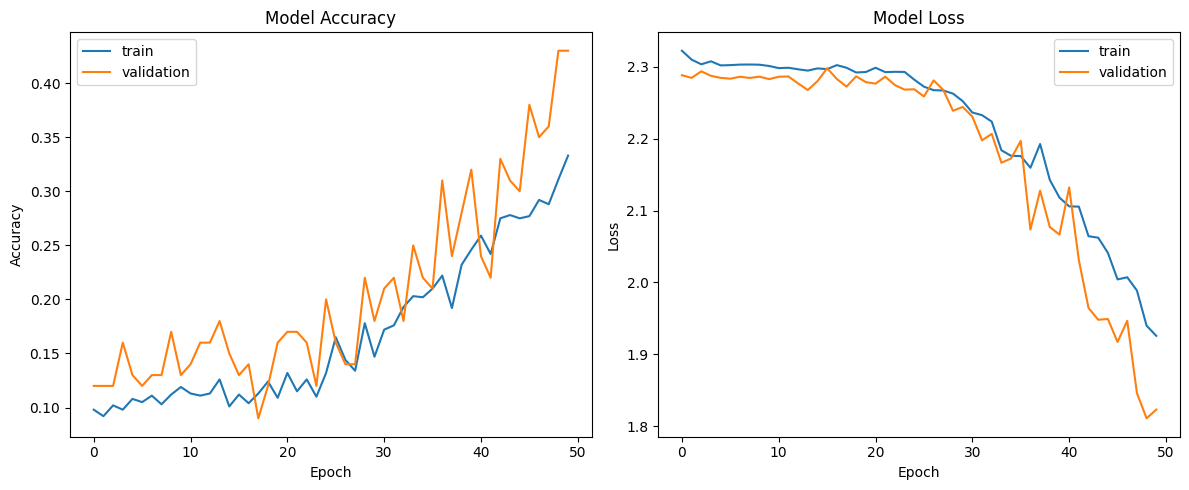

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0964 - loss: 2.6281  
ความแม่นยำบนชุดข้อมูลทดสอบ: 0.0850
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


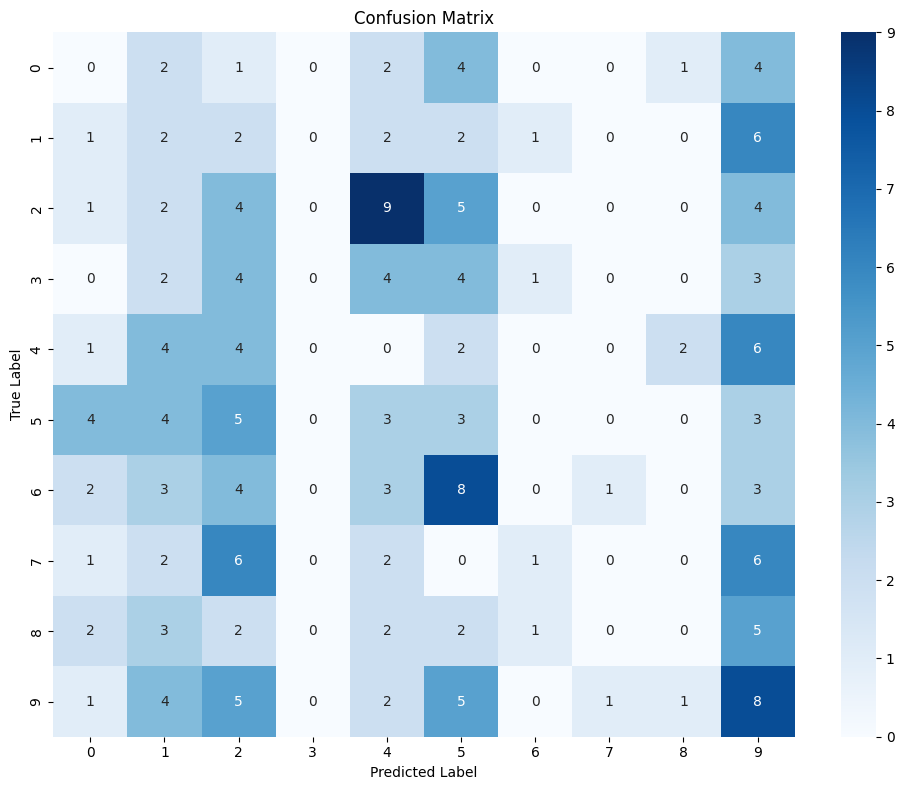

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
คู่ของข้อผิดพลาดที่พบบ่อยที่สุด 5 คู่:
  ป้ายกำกับจริง: 2, ทำนายเป็น: 4, จำนวน: 9 ครั้ง
  ป้ายกำกับจริง: 6, ทำนายเป็น: 5, จำนวน: 8 ครั้ง
  ป้ายกำกับจริง: 1, ทำนายเป็น: 9, จำนวน: 6 ครั้ง
  ป้ายกำกับจริง: 7, ทำนายเป็น: 2, จำนวน: 6 ครั้ง
  ป้ายกำกับจริง: 7, ทำนายเป็น: 9, จำนวน: 6 ครั้ง
กำลังแปลงโมเดลเป็น TFLite...
Saved artifact at '/tmp/tmpyd57cgil'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 42, 3), dtype=tf.float32, name='keras_tensor_54')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  135912105498512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135912105501008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135912105501584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135912105500624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135912105502160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13591210550

In [86]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import pandas as pd

class SignLanguageModelTrainer:
  def __init__(self, model_selector, best_model=None, best_model_name=None):
        """
        ฝึกอบรมและปรับปรุงโมเดลภาษามือที่ดีที่สุด

        Args:
            model_selector: อ็อบเจ็กต์ SignLanguageModelSelector ที่ใช้ก่อนหน้านี้
            best_model: โมเดลที่ดีที่สุดจากการปรับแต่งพารามิเตอร์ (หากมี)
            best_model_name: ชื่อสถาปัตยกรรมที่ดีที่สุด (LSTM, CNN, Transformer)
        """
        self.model_selector = model_selector
        self.X_train = model_selector.X_train
        self.y_train = model_selector.y_train
        self.X_test = model_selector.X_test
        self.y_test = model_selector.y_test
        self.best_model = best_model
        self.best_model_name = best_model_name
        self.num_classes = len(np.unique(self.y_train))

  def prepare_best_model(self, model_comparison=None):
        """
        เตรียมโมเดลที่ดีที่สุดสำหรับการเทรนอย่างละเอียด

        Args:
            model_comparison: ผลลัพธ์จาก model_selector.compare_models()

        Returns:
            โมเดลที่ดีที่สุดพร้อมค่าพารามิเตอร์เริ่มต้น
        """
        if self.best_model is not None:
            print(f"ใช้โมเดลที่กำหนดไว้: {self.best_model_name}")
            return self.best_model

        if model_comparison is not None:
            # หาโมเดลที่ดีที่สุดจากความแม่นยำ
            best_acc = 0
            for name, results in model_comparison.items():
                if results['test_accuracy'] > best_acc:
                    best_acc = results['test_accuracy']
                    self.best_model_name = name

            print(f"โมเดลที่ดีที่สุดจากการเปรียบเทียบ: {self.best_model_name} (ความแม่นยำ: {best_acc:.4f})")

#สร้างโมเดลใหม่ตามสถาปัตยกรรมที่ดีที่สุด
            if self.best_model_name == 'LSTM':
                self.best_model = self.model_selector.create_lstm_model()
            elif self.best_model_name == 'CNN':
                self.best_model = self.model_selector.create_cnn_model()
            elif self.best_model_name == 'Transformer':
                self.best_model = self.model_selector.create_transformer_model()
            else:
                raise ValueError("ไม่พบชื่อโมเดลที่ถูกต้อง")

            return self.best_model

#ถ้าไม่มีข้อมูลเปรียบเทียบโมเดล ให้ใช้ LSTM เป็นค่าเริ่มต้น
        print("ไม่มีการเปรียบเทียบโมเดล ใช้ LSTM เป็นค่าเริ่มต้น")
        self.best_model_name = 'LSTM'
        self.best_model = self.model_selector.create_lstm_model()
        return self.best_model

  def create_data_augmentation(self):
    """
    สร้างฟังก์ชันสำหรับเพิ่มข้อมูล

    Returns:
        ฟังก์ชันสำหรับเพิ่มข้อมูล
    """
    def augment_sequence(sequence, label):
        # แปลงเป็น tensor โดยไม่ระบุ dtype เพื่อให้ใช้ชนิดเดิมของข้อมูล
        # หรือแปลงข้อมูลเป็น float32 ก่อนเรียกฟังก์ชันนี้
        sequence = tf.cast(sequence, tf.float32)  # แก้ไขตรงนี้

        # เพิ่มสัญญาณรบกวน (Gaussian noise)
        if tf.random.uniform([]) < 0.5:
            noise = tf.random.normal(shape=tf.shape(sequence), mean=0.0, stddev=0.05)
            sequence = sequence + noise

        # สลับเวลา (Time shifting)
        if tf.random.uniform([]) < 0.5:
            shift = tf.random.uniform([], minval=-3, maxval=3, dtype=tf.int32)
            sequence = tf.roll(sequence, shift, axis=0)

        # สเกลแอมพลิจูด (Amplitude scaling)
        if tf.random.uniform([]) < 0.5:
            scale = tf.random.uniform([], minval=0.8, maxval=1.2)
            sequence = sequence * scale

        # หมุนและเอียง (ทำกับข้อมูลที่เป็นตำแหน่ง x, y, z)
        # สมมติว่าข้อมูลมี dimension เป็น [timesteps, features, channels]
        # ให้ปรับการหมุนให้เข้ากับรูปร่างข้อมูลที่มี 3 มิติ

        return sequence, label

    return augment_sequence

  def create_train_dataset(self, batch_size=32, use_augmentation=True):
        """
        สร้าง dataset สำหรับการเทรน

        Args:
            batch_size: ขนาด batch
            use_augmentation: ใช้การเพิ่มข้อมูลหรือไม่

        Returns:
            tf.data.Dataset สำหรับการเทรน
        """
        train_dataset = tf.data.Dataset.from_tensor_slices((self.X_train, self.y_train))

        if use_augmentation:
            augment_func = self.create_data_augmentation()
            train_dataset = train_dataset.map(augment_func, num_parallel_calls=tf.data.AUTOTUNE)

        train_dataset = train_dataset.shuffle(buffer_size=len(self.X_train))
        train_dataset = train_dataset.batch(batch_size)
        train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

        return train_dataset

  def create_validation_dataset(self, batch_size=32):
        # ตรวจสอบว่ามีข้อมูลเพียงพอสำหรับการแบ่ง
      if len(self.X_train) < 10:  # ถ้าข้อมูลน้อยเกินไป
          # ใช้ข้อมูลเดียวกันกับชุดข้อมูลทดสอบ
          X_val = self.X_test
          y_val = self.y_test
      else:
          # แยก validation set จาก training set
          val_split = int(len(self.X_train) * 0.9)
          X_val = self.X_train[val_split:]
          y_val = self.y_train[val_split:]

      val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
      val_dataset = val_dataset.batch(batch_size)
      val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

      return val_dataset

  def train_with_progressive_learning(self, epochs=300, batch_size=32, patience=20):
        """
        ฝึกอบรมโมเดลด้วยการเรียนรู้แบบก้าวหน้า

        Args:
            epochs: จำนวนรอบการเทรนทั้งหมด
            batch_size: ขนาด batch
            patience: จำนวนรอบที่รอก่อนที่จะหยุดเมื่อไม่มีการปรับปรุง

        Returns:
            ประวัติการเทรน
        """
        # เตรียมโมเดล
        model = self.prepare_best_model()

        # Callbacks
        callbacks = [
            # บันทึกโมเดลที่ดีที่สุด
            ModelCheckpoint(
                f'best_{self.best_model_name}_model.h5',
                monitor='val_accuracy',
                save_best_only=True,
                mode='max',
                verbose=1
            ),
            # ลด learning rate เมื่อไม่มีการปรับปรุง
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=10,
                min_lr=1e-6,
                verbose=1
            ),
            # หยุดเมื่อไม่มีการปรับปรุง
            EarlyStopping(
                monitor='val_loss',
                patience=patience,
                restore_best_weights=True,
                verbose=1
            )
        ]

        # สร้าง datasets
        train_dataset = self.create_train_dataset(batch_size=batch_size)
        val_dataset = self.create_validation_dataset(batch_size=batch_size)

        # ฝึกอบรมโมเดล
        history = model.fit(
            train_dataset,
            epochs=epochs,
            validation_data=val_dataset,
            callbacks=callbacks,
            verbose=1
        )

        # บันทึกโมเดลสุดท้าย
        model.save(f'final_{self.best_model_name}_model.h5')

        self.best_model = model  # อัปเดตโมเดลที่ดีที่สุด

        return history

  def evaluate_model(self):
        """
        ประเมินโมเดลบนชุดข้อมูลทดสอบ

        Returns:
            ผลการประเมิน
        """
        if self.best_model is None:
            raise ValueError("โมเดลยังไม่ได้รับการฝึกอบรม")

        # ประเมินบนชุดข้อมูลทดสอบ
        test_loss, test_acc = self.best_model.evaluate(self.X_test, self.y_test)
        print(f"ความแม่นยำบนชุดข้อมูลทดสอบ: {test_acc:.4f}")

        # ทำนายคลาส
        y_pred = np.argmax(self.best_model.predict(self.X_test), axis=1)

        # สร้าง confusion matrix
        cm = confusion_matrix(self.y_test, y_pred)

        # สร้างรายงานการจำแนก
        report = classification_report(self.y_test, y_pred, output_dict=True)

        return {
            'test_accuracy': test_acc,
            'test_loss': test_loss,
            'confusion_matrix': cm,
            'classification_report': report
        }

  def plot_training_history(self, history):
        """
        วาดกราฟประวัติการเทรน

        Args:
            history: ประวัติการเทรนจาก model.fit()
        """
        # สร้างกราฟ
        plt.figure(figsize=(12, 5))

        # กราฟค่า accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='train')
        plt.plot(history.history['val_accuracy'], label='validation')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # กราฟค่า loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='validation')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.savefig(f'{self.best_model_name}_training_history.png')
        plt.show()

  def plot_confusion_matrix(self, cm, class_names=None):
        """
        วาดกราฟ confusion matrix

        Args:
            cm: confusion matrix
            class_names: ชื่อคลาส (หากมี)
        """
        if class_names is None:
            class_names = [str(i) for i in range(self.num_classes)]

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names,
                   yticklabels=class_names)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.savefig(f'{self.best_model_name}_confusion_matrix.png')
        plt.show()

  def analyze_errors(self, top_n=5):
        """
        วิเคราะห์ข้อผิดพลาดที่พบบ่อย

        Args:
            top_n: จำนวนคู่ของความผิดพลาดที่พบบ่อยที่สุดที่จะแสดง
        """
        # ทำนายบนชุดข้อมูลทดสอบ
        y_pred = np.argmax(self.best_model.predict(self.X_test), axis=1)

        # หาตัวอย่างที่ทำนายผิด
        misclassified_indices = np.where(y_pred != self.y_test)[0]

        if len(misclassified_indices) == 0:
            print("ไม่พบข้อผิดพลาดในการทำนาย!")
            return

        # สร้างตารางคู่ของ (ป้ายกำกับจริง, ป้ายกำกับที่ทำนาย)
        error_pairs = [(self.y_test[i], y_pred[i]) for i in misclassified_indices]

        # นับความถี่ของแต่ละคู่
        error_counts = {}
        for true_label, pred_label in error_pairs:
            key = (true_label, pred_label)
            if key in error_counts:
                error_counts[key] += 1
            else:
                error_counts[key] = 1

        # เรียงลำดับตามความถี่
        sorted_errors = sorted(error_counts.items(), key=lambda x: x[1], reverse=True)

        # แสดงคู่ที่พบบ่อยที่สุด
        print(f"คู่ของข้อผิดพลาดที่พบบ่อยที่สุด {min(top_n, len(sorted_errors))} คู่:")
        for (true_label, pred_label), count in sorted_errors[:top_n]:
            print(f"  ป้ายกำกับจริง: {true_label}, ทำนายเป็น: {pred_label}, จำนวน: {count} ครั้ง")

  def export_model_for_deployment(self, model_format='tflite'):
      """
      ส่งออกโมเดลสำหรับการนำไปใช้งาน

      Args:
          model_format: รูปแบบของโมเดลที่จะส่งออก ('tflite' หรือ 'saved_model')

      Returns:
          พาธไปยังโมเดลที่ส่งออก
      """
      if self.best_model is None:
          raise ValueError("โมเดลยังไม่ได้รับการฝึกอบรม")

      if model_format == 'tflite':
          try:
              # แปลงเป็น TFLite
              converter = tf.lite.TFLiteConverter.from_keras_model(self.best_model)

              # ตั้งค่าพิเศษเพื่อเพิ่มความเข้ากันได้
              converter.target_spec.supported_ops = [
                  tf.lite.OpsSet.TFLITE_BUILTINS,  # ใช้ operator ที่มีมาตรฐานใน TFLite
                  tf.lite.OpsSet.SELECT_TF_OPS     # ใช้ operator ของ TensorFlow ถ้าจำเป็น
              ]

              # ตั้งค่าเพิ่มเติมเพื่อให้ conversion สำเร็จ
              converter.allow_custom_ops = True
              converter.experimental_new_converter = True

              # ลองลดขนาดโมเดล
              converter.optimizations = [tf.lite.Optimize.DEFAULT]

              # แปลงโมเดล
              print("กำลังแปลงโมเดลเป็น TFLite...")
              tflite_model = converter.convert()

              # บันทึกไฟล์
              model_path = f'{self.best_model_name}_model.tflite'
              with open(model_path, 'wb') as f:
                  f.write(tflite_model)

              print(f"ส่งออกโมเดล TFLite แล้วที่: {model_path}")
              return model_path

          except Exception as e:
              print(f"เกิดข้อผิดพลาดในการแปลงเป็น TFLite: {e}")
              print("ลองส่งออกในรูปแบบ SavedModel แทน...")
              # ส่งออกในรูปแบบ SavedModel เป็นตัวเลือกสำรอง
              return self.export_model_for_deployment(model_format='saved_model')

      elif model_format == 'saved_model':
          try:
              # บันทึกในรูปแบบ SavedModel
              model_path = f'{self.best_model_name}_saved_model'
              tf.saved_model.save(self.best_model, model_path)

              print(f"ส่งออกโมเดล SavedModel แล้วที่: {model_path}")
              return model_path
          except Exception as e:
              print(f"เกิดข้อผิดพลาดในการส่งออกเป็น SavedModel: {e}")
              print("ลองส่งออกในรูปแบบ h5 แทน...")

              # ส่งออกในรูปแบบ h5 เป็นตัวเลือกสำรอง
              model_path = f'{self.best_model_name}_model.h5'
              self.best_model.save(model_path)
              print(f"ส่งออกโมเดลในรูปแบบ h5 แล้วที่: {model_path}")
              return model_path

      else:
          raise ValueError("รูปแบบโมเดลไม่ถูกต้อง ต้องเป็น 'tflite' หรือ 'saved_model'")
# ตัวอย่างการใช้งาน
def main():
    # สมมติว่าเรามีอ็อบเจ็กต์ SignLanguageModelSelector ที่สร้างไว้แล้ว
    # และได้ทำการเปรียบเทียบโมเดลแล้ว
    # model_selector = SignLanguageModelSelector(X_train, y_train, X_test, y_test)
    # model_comparison = model_selector.compare_models()

    # ในกรณีที่ต้องการทดสอบโดยไม่มี model_selector จริง
    class DummyModelSelector:

      def __init__(self):
          # สร้างข้อมูลสมมติที่มีรูปร่าง 4 มิติ
          self.X_train = np.random.random((1000, 30, 42, 3))  # เพิ่มมิติสุดท้าย
          self.y_train = np.random.randint(0, 10, 1000)
          self.X_test = np.random.random((200, 30, 42, 3))    # เพิ่มมิติสุดท้าย
          self.y_test = np.random.randint(0, 10, 200)

      # แก้ไขโมเดลให้รับข้อมูล 4 มิติ...
      def create_lstm_model(self):
          model = tf.keras.Sequential([
              # เพิ่ม Reshape layer
              tf.keras.layers.Reshape((30, 42*3), input_shape=(30, 42, 3)),
              tf.keras.layers.LSTM(64, return_sequences=True),
              tf.keras.layers.Dropout(0.3),
              tf.keras.layers.LSTM(32),
              tf.keras.layers.Dense(10, activation='softmax')
          ])
          model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
          return model

      def create_cnn_model(self):
          model = tf.keras.Sequential([
              # ใช้ Conv2D แทน Conv1D
              tf.keras.layers.Conv2D(64, (3, 3), input_shape=(30, 42, 3), activation='relu'),
              tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(10, activation='softmax')
          ])
          model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
          return model

      def create_transformermodel(self):
          inputs = tf.keras.Input(shape=(30, 42, 3))
          # แบนมิติสุดท้าย
          x = tf.keras.layers.Reshape((30, 42*3))(inputs)
          for _ in range(2):
              x = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
              x = tf.keras.layers.LayerNormalization()(x)
          x = tf.keras.layers.GlobalAveragePooling1D()(x)
          x = tf.keras.layers.Dense(32, activation='relu')(x)
          outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
          model = tf.keras.Model(inputs=inputs, outputs=outputs)
          model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
          return model

# สร้างอ็อบเจ็กต์ trainer
    model_selector = DummyModelSelector()
    trainer = SignLanguageModelTrainer(model_selector, best_model_name='LSTM')

    # เทรนโมเดล
    history = trainer.train_with_progressive_learning(epochs=50, batch_size=32)

    # วาดกราฟประวัติการเทรน
    trainer.plot_training_history(history)

    # ประเมินโมเดล
    eval_results = trainer.evaluate_model()

    # วาดกราฟ confusion matrix
    trainer.plot_confusion_matrix(eval_results['confusion_matrix'])

    # วิเคราะห์ข้อผิดพลาด
    trainer.analyze_errors()

    # ส่งออกโมเดลสำหรับการนำไปใช้งาน
    trainer.export_model_for_deployment()


if __name__ == '__main__':
    main()

# Test


In [83]:
import cv2
import numpy as np
import tensorflow as tf
import mediapipe as mp

class SignLanguageTranslator:
    def __init__(self, model_path):
        # โหลดโมเดลที่ได้จากการเทรนเพิ่มเติม
        self.model = tf.keras.models.load_model(model_path)

        # ตั้งค่า MediaPipe Hands สำหรับการตรวจจับมือ
        self.mp_hands = mp.solutions.hands
        self.hands = self.mp_hands.Hands(
            static_image_mode=False,
            max_num_hands=1,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5
        )

        # คำแปลสัญญาณมือ (ตัวอย่าง)
        self.sign_labels = ["สวัสดี", "ขอบคุณ", "ช่วยเหลือ", "หิว", "น้ำ", ...]

        # ตัวแปรสำหรับเก็บตำแหน่งมือ
        self.sequence = []
        self.sequence_length = 30  # ต้องตรงกับ input shape ของโมเดล

    def extract_hand_landmarks(self, frame):
        # แปลงสีและประมวลผลภาพ
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = self.hands.process(image)

        # เริ่มต้นด้วยค่าว่างเปล่า
        landmarks = np.zeros(42)  # 21 landmarks x 2 (x, y)

        if results.multi_hand_landmarks:
            hand_landmarks = results.multi_hand_landmarks[0]  # เลือกมือแรก

            # แปลงตำแหน่งเป็น array ขนาด 42
            landmarks_array = []
            for landmark in hand_landmarks.landmark:
                landmarks_array.extend([landmark.x, landmark.y])

            landmarks = np.array(landmarks_array)

        return landmarks

    def update_sequence(self, landmarks):
        # เพิ่มตำแหน่งมือใหม่เข้าไปในลำดับ
        self.sequence.append(landmarks)

        # คงความยาวของลำดับที่ sequence_length
        if len(self.sequence) > self.sequence_length:
            self.sequence = self.sequence[-self.sequence_length:]

    def predict_sign(self):
        # ตรวจสอบว่ามีข้อมูลเพียงพอหรือไม่
        if len(self.sequence) < self.sequence_length:
            return None

        # แปลงลำดับเป็น array รูปแบบที่โมเดลต้องการ
        X = np.array([self.sequence])

        # ทำนายด้วยโมเดล
        prediction = self.model.predict(X)[0]

        # หาคลาสที่มีความน่าจะเป็นสูงสุด
        predicted_class = np.argmax(prediction)
        confidence = prediction[predicted_class]

        # แสดงผลเฉพาะเมื่อความมั่นใจสูงพอ
        if confidence > 0.7:
            return self.sign_labels[predicted_class], confidence
        else:
            return None

    def run_webcam(self):
        cap = cv2.VideoCapture(0)

        while cap.isOpened():
            success, frame = cap.read()
            if not success:
                continue

            # สกัดตำแหน่งมือ
            landmarks = self.extract_hand_landmarks(frame)

            # อัปเดตลำดับ
            self.update_sequence(landmarks)

            # ทำนายสัญญาณมือ
            result = self.predict_sign()

            # แสดงผลการทำนาย
            if result:
                sign, confidence = result
                cv2.putText(frame, f"{sign} ({confidence:.2f})", (50, 50),
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            # แสดงเฟรม
            cv2.imshow('Sign Language Translator', frame)

            # กดปุ่ม q เพื่อออก
            if cv2.waitKey(5) & 0xFF == ord('q'):
                break

        cap.release()
        cv2.destroyAllWindows()

# ตัวอย่างการใช้งาน
translator = SignLanguageTranslator('final_LSTM_model.h5')
translator.run_webcam()

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'final_LSTM_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)